# Shape approximation of a spherical-cap bubble

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>



In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import torch

%matplotlib notebook
print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("PyTorch version: {}".format(torch.__version__))

Pandas version: 0.24.2
Numpy version: 1.16.2
PyTorch version: 1.0.0


## Volume-of-fluid data<a id="vof_data"></a>

In [136]:
data = pd.read_csv("bhaga_03_l16.csv", header=0)
print("The data set contains {} points.".format(data.shape[0]))
data.head()

The data set contains 1170 points.


,px,py
0,-0.157689,0.596598
1,-0.157689,0.596924
2,-0.157689,0.596924
3,-0.158289,0.600586
4,-0.158289,0.600586


<IPython.core.display.Javascript object>


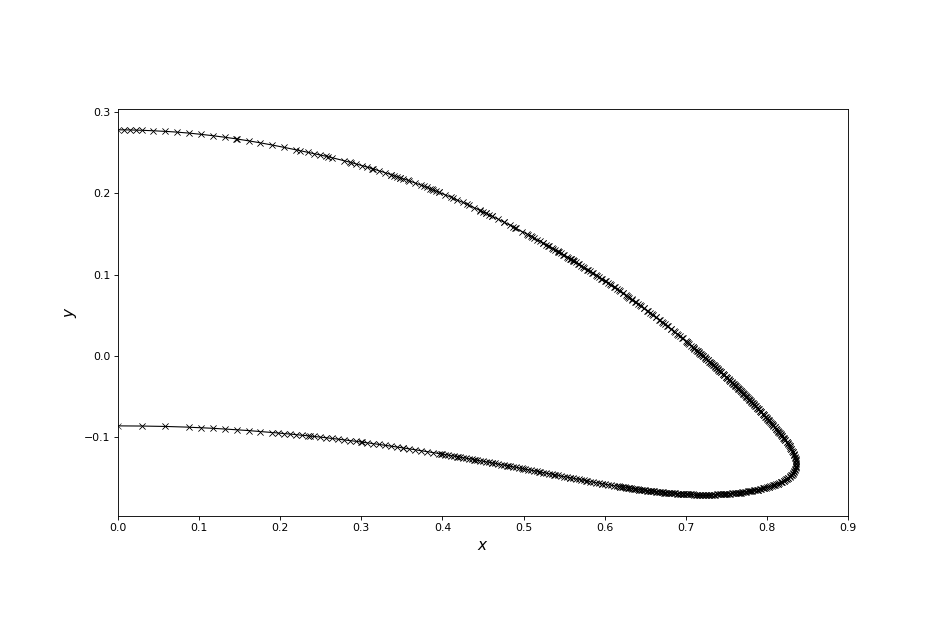

In [137]:
fontsize = 14

fig, ax = plt.subplots(figsize=(12, 8))

line_segments = [[(data.py[i], data.px[i]),(data.py[i+1], data.px[i+1])] for i in range(0, data.shape[0] - 1, 2) ]
lc = mc.LineCollection(line_segments, linewidths=1, colors='k')
ax.add_collection(lc)
ax.autoscale()

x = [i[0] for j in line_segments for i in j]
y = [i[1] for j in line_segments for i in j]
ax.scatter(x, y, marker='x', color='k', s=30, linewidth=0.5)

ax.set_aspect('equal')
ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$y$", fontsize=fontsize)
ax.set_xlim(0.0, 0.9)
plt.show()

## Parameterization<a id="parameterization"></a>

In [123]:
def polar_coordinates(px, py):
    '''Converts raduis from Cartesian coordinates r(x,y) to polar coordinates r(phi)
    
    Parameters
    ----------
    px, py - array-like: x and y coordinates of PLIC points
    
    Returns
    -------
    radius - array-like: radii of PLIC points
    phi - array-like: polar angle
    
    '''
    radius = np.sqrt(np.square(px) + np.square(py))
    phi = np.arccos(py / radius)
    return radius, phi

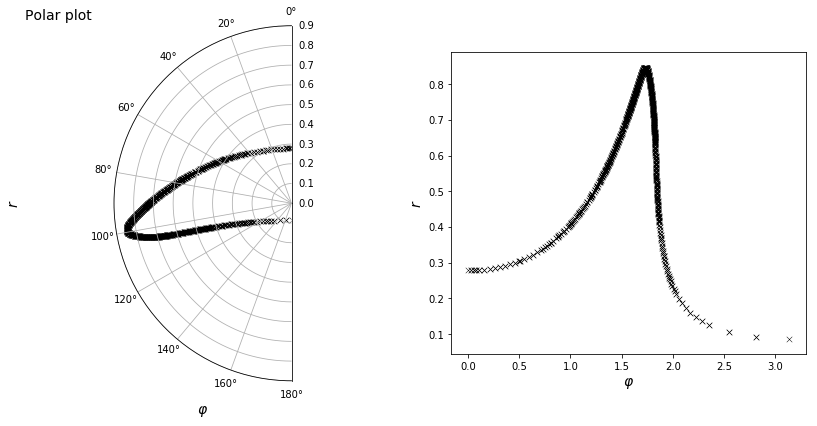

In [139]:
%matplotlib inline

fig = plt.figure(figsize=(14,10))
ax1 = plt.subplot(121, projection='polar')
ax2 = plt.subplot(122)

radius, phi = polar_coordinates(data.py, data.px)

ax1.set_theta_zero_location("N")
ax1.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax1.set_xlim(0.0, np.pi)
ax1.set_title("Polar plot", loc='left', fontsize=fontsize)
ax1.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax1.set_ylabel(r"$r$", fontsize=fontsize)

ax2.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax2.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax2.set_ylabel(r"$r$", fontsize=fontsize)
asp = np.diff(ax1.get_xlim())[0] / np.diff(ax1.get_ylim())[0]
ax2.set_aspect(asp)
    
plt.show()

## Simple function approximation<a id="function_approximation"></a>

In [140]:
torch.set_default_tensor_type(torch.DoubleTensor)

class SimpleMLP(torch.nn.Module):
    def __init__(self, n_inputs=1, n_outputs=1, n_layers=1, n_neurons=10, activation=torch.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.n_layers = n_layers
        self.n_neurons = n_neurons
        self.activation = activation
        self.layers = torch.nn.ModuleList()
        # input layer to first hidden layer
        self.layers.append(torch.nn.Linear(self.n_inputs, self.n_neurons))
        # add more hidden layers if specified
        if self.n_layers > 1:
            for hidden in range(self.n_layers-1):
                self.layers.append(torch.nn.Linear(self.n_neurons, self.n_neurons))
        # last hidden layer to output layer
        self.layers.append(torch.nn.Linear(self.n_neurons, self.n_outputs))
        
    def forward(self, x):
        for i_layer in range(self.n_layers):
            x = self.activation(self.layers[i_layer](x))
        return self.layers[-1](x)

In [141]:
def approximate_function(x, y, model, l_rate=0.001, max_iter=1000, path=None):
    '''Train MLP to approximate a function y(x).
       The training stops when the maximum number of training epochs is reached.
    
    Parameters
    ----------
    x - array-like    : argument of the function
    y - array-like    : function value at x
    model - SimpleMLP : PyTorch model which is adjusted to approximate the function
    l_rate - Float    : learning rate for weight optimization
    max_iter - Integer: maximum number of allowed training epochs
    path - String     : location to save model weights
    
    Returns
    -------
    model - SimpleMLP: trained version of the given model
    
    '''
    # convert coordinates to torch tensors
    x_tensor = torch.from_numpy(x).unsqueeze_(-1)
    y_tensor = torch.from_numpy(y)
    # define loss function
    criterion = torch.nn.MSELoss()
    # define optimizer
    optimizer = torch.optim.Adam(params=model.parameters(), lr=l_rate)
    
    # training loop
    best_loss = 1.0E5
    for e in range(1, max_iter+1):
        # backpropagation
        optimizer.zero_grad()
        output = model.forward(x_tensor)
        loss = criterion(output.squeeze(dim=1), y_tensor)
        loss.backward()
        optimizer.step()
        # check error
        diff = output.squeeze(dim=1) - y_tensor
        max_diff = np.amax(np.absolute(diff.detach().numpy()))
        if loss.item() < best_loss:
            best_loss = loss.item()
            print("Loss/max. dev. decreased in epoch {}: {}/{}".format(e, loss.item(), max_diff))
            print("Saving model as {}".format(path))
            if path is not None:
                torch.save(model.state_dict(), path)
    return model.eval()

## Direkt approximation of the radius<a id="direct_approximation"></a>

In [142]:
radius_model_direct = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_direct = approximate_function(phi.values, radius.values, radius_model_direct, max_iter=1500,
                                           l_rate=0.01, path="radius_model_direct.pt")

Loss/max. dev. decreased in epoch 1: 0.15394974018060814/0.5694468030033608
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 2: 0.03465547228589401/0.6043487165569276
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 6: 0.033063493841457486/0.4927838542669519
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 11: 0.03129718057451097/0.5169343210400701
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 18: 0.031223018095105144/0.5184990361230327
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 24: 0.030722883070122317/0.5363199944022331
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 37: 0.030698177762870944/0.5400490703902632
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 61: 0.030695429929220055/0.5408911316729863
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 72: 0.030694930824897/0.540524682107

Loss/max. dev. decreased in epoch 183: 0.021232251287340246/0.587948786347969
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 184: 0.02122288789336231/0.5883713428777966
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 185: 0.021215122553897816/0.5885194819375723
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 186: 0.021209188936114294/0.5883748667668098
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 187: 0.02120323596893497/0.5881000584846964
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 188: 0.02119562162761302/0.5879908268302177
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 189: 0.021186910677152646/0.5881092734148414
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 190: 0.02117959443377221/0.5882842350123625
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 191: 0.02117544250515078/0.

Loss/max. dev. decreased in epoch 288: 0.021100616929405312/0.5886215320383995
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 289: 0.021100422669708078/0.5886253742405073
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 290: 0.021100231110269835/0.5886281364676826
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 291: 0.02110004210076991/0.5886283977860027
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 292: 0.021099855516971532/0.5886267289220956
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 293: 0.02109967137305812/0.5886253716363328
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 294: 0.021099489699678287/0.5886253819700278
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 295: 0.02109931042303211/0.5886266515279676
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 296: 0.02109913343524473/

Loss/max. dev. decreased in epoch 365: 0.02109086259187874/0.5886732179418723
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 366: 0.021090782342690118/0.5886737281116137
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 367: 0.021090702858758286/0.58867422800684
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 368: 0.02109062412869462/0.5886747535742349
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 369: 0.02109054614125091/0.5886753010855913
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 370: 0.02109046888537821/0.5886758690276179
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 371: 0.021090392350197655/0.5886764309453817
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 372: 0.021090316524944457/0.5886769470605375
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 373: 0.021090241398989847/0.

Loss/max. dev. decreased in epoch 443: 0.02108618999013359/0.588694247631718
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 444: 0.021086142189753965/0.5886941274619119
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 445: 0.021086094479832652/0.5886939955224529
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 446: 0.021086046857552873/0.588693852261515
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 447: 0.021085999321361053/0.5886936977413809
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 448: 0.021085951871096197/0.588693531644859
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 449: 0.0210859045081086/0.588693354933788
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 450: 0.021085857235368897/0.5886931688052903
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 451: 0.021085810057555353/0.5

Loss/max. dev. decreased in epoch 521: 0.021083075304147568/0.5886916800924937
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 522: 0.021083043512508278/0.5886917718479624
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 523: 0.02108301187892447/0.588691864758281
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 524: 0.021082980401894085/0.5886919585781255
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 525: 0.021082949079909877/0.5886920530479332
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 526: 0.021082917911463203/0.5886921479273325
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 527: 0.021082886895047292/0.5886922430070537
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 528: 0.021082856029160456/0.588692338095918
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 529: 0.021082825312307294

Loss/max. dev. decreased in epoch 595: 0.021081058311897077/0.5886980667060905
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 596: 0.021081034513829804/0.5886981395605188
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 597: 0.02108101077765031/0.5886982118532145
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 598: 0.021080987102236947/0.5886982835769932
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 599: 0.02108096348647032/0.5886983547226513
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 600: 0.02108093992923267/0.5886984252793032
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 601: 0.02108091642940802/0.5886984952344289
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 602: 0.021080892985881606/0.588698564574998
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 603: 0.021080869597540346/0

Loss/max. dev. decreased in epoch 692: 0.02107886650777406/0.5886964925988427
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 693: 0.02107884361377041/0.5887080581187117
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 694: 0.021078821604480807/0.5886894355868504
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 695: 0.021078802034102312/0.5887192816903707
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 696: 0.021078788957806304/0.5886710010530682
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 706: 0.021078624183790945/0.5885797264900513
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 710: 0.02107848848536949/0.5887157019609358
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 714: 0.021078407682795217/0.5887682899761384
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 721: 0.02107822424284063/

Loss/max. dev. decreased in epoch 826: 0.021073061249817792/0.588653632354602
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 827: 0.02107290202154321/0.5886518433562682
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 828: 0.02107273161890421/0.5886471311435081
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 829: 0.02107254836607632/0.5886472135569089
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 830: 0.02107235026788883/0.5886428761800716
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 831: 0.021072134866614706/0.5886391220416257
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 832: 0.021071899068055146/0.5886376981516394
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 833: 0.021071638983039154/0.5886315246510093
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 834: 0.02107134967196405/0.

Loss/max. dev. decreased in epoch 965: 0.00023495950343767742/0.1386114938025359
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 967: 0.00023471176434103623/0.1391403602382692
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 968: 0.00023251615362839543/0.13891765732990913
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 970: 0.00022897913789832305/0.1382169553205081
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 972: 0.0002285287457918766/0.13641069352087132
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 973: 0.00022545785390977943/0.13672402795302596
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 975: 0.00022336687881447748/0.13621076019769363
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 976: 0.00022271515289508858/0.13586063098391388
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 97

Loss/max. dev. decreased in epoch 1038: 0.00016520976760126075/0.12529960877674473
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1039: 0.000164464260074261/0.12503356683280592
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1040: 0.00016371717752718207/0.1249099500211134
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1041: 0.00016297687076868554/0.12473334137248439
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1042: 0.0001622418441751034/0.12449510924030384
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1043: 0.00016150555376511508/0.12437846004577148
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1044: 0.0001607719798549065/0.12416178711374042
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1045: 0.00016004414539462508/0.12395179951992662
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in e

Loss/max. dev. decreased in epoch 1188: 0.00010286544970819131/0.10147795082277315
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1189: 0.00010266896045788793/0.10144206179699021
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1190: 0.00010260477568621807/0.10036219414832355
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1191: 0.00010169001964650352/0.10092562546474
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1192: 0.00010133458908097117/0.10078047609143327
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1193: 0.00010126285347759419/0.09987610216041974
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1194: 0.00010054061844343219/0.10037010496233857
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1195: 0.00010008429807110445/0.10007426820984723
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in

Loss/max. dev. decreased in epoch 1289: 7.383851152418399e-05/0.07692815308654437
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1290: 7.362005630660005e-05/0.07668911559265583
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1291: 7.340208067552355e-05/0.07645188789796702
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1292: 7.318454683036915e-05/0.0762210463643503
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1293: 7.296741966138322e-05/0.07598087125431262
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1294: 7.275069762568023e-05/0.07574807151170872
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1295: 7.253438147451602e-05/0.0755147633188493
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1296: 7.231844177515367e-05/0.07527639826626363
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 1392: 4.5361981583108545e-05/0.0407813508469928
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1396: 4.1653902736459515e-05/0.03707791866804913
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1400: 3.963742090478192e-05/0.03406800455689346
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1404: 3.83459464635735e-05/0.03111350384920572
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1408: 3.701568893708432e-05/0.028719506401272604
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1412: 3.569081675732723e-05/0.027853547223137154
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1416: 3.4405515071391876e-05/0.025275100402821493
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in epoch 1420: 3.318262983047204e-05/0.023343496676802786
Saving model as radius_model_direct.pt
Loss/max. dev. decreased in

Maximum relative deviation: 2.44% at angle 1.85.


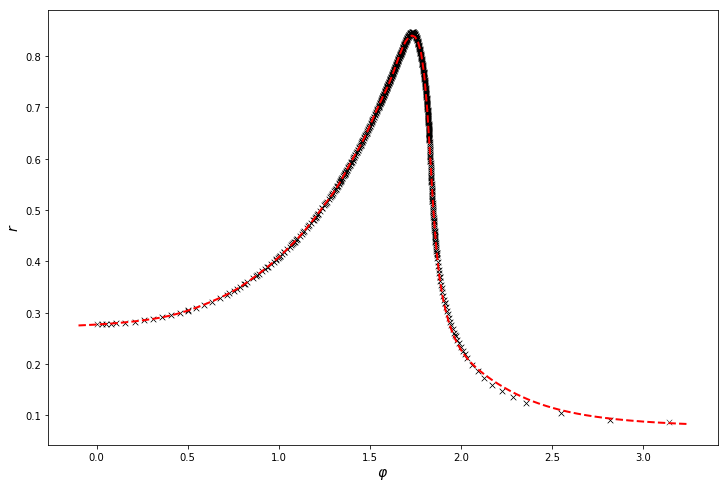

In [143]:
fig, ax = plt.subplots(figsize=(12, 8))

eval_phi = np.linspace(-0.1, np.pi+0.1, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
# load best weights and compute forward pass
radius_model_direct.load_state_dict(torch.load("radius_model_direct.pt"))
model_radius = radius_model_direct.forward(phi_tensor).detach().squeeze().numpy()
phi_data_tensor = torch.from_numpy(phi.values).unsqueeze_(-1)
# evaluate maximum relative deviation
model_radius_data = radius_model_direct.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius.values)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius.values[diff_max_pos] * 100, phi.values[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

## Using prior/domain knowledge<a id="prior_knowledge"></a>

### Re-scaling the data<a id="rescaling"></a>

The variance of the original radius is 0.0307.
The variance of the scaled radius is 0.0046.


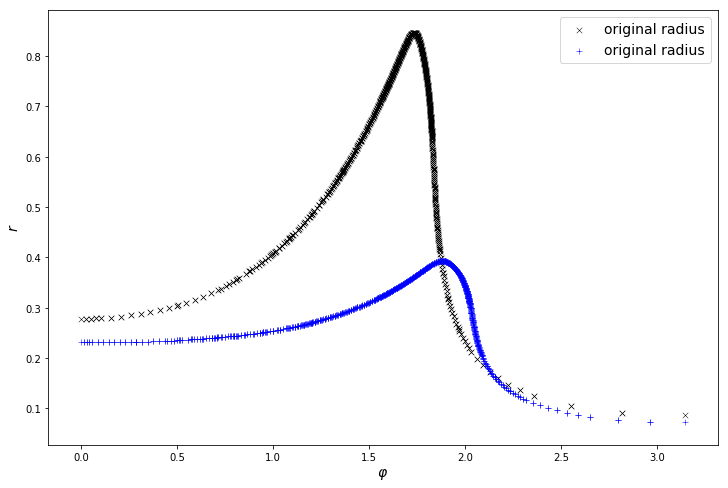

In [144]:
px_scaled = data.px.values * abs(np.amax(data.py.values) - np.amin(data.py.values))
py_scaled = data.py.values * abs(np.amax(data.px.values) - np.amin(data.px.values))

radius_scaled, phi_scaled = polar_coordinates(py_scaled, px_scaled)

print("The variance of the original radius is {:1.4f}.".format(np.var(radius.values)))
print("The variance of the scaled radius is {:1.4f}.".format(np.var(radius_scaled)))

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(phi, radius, marker='x', color='k', s=30, linewidth=0.5, label=r"original radius")
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5, label=r"original radius")
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

In [145]:
radius_model_scaled = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_scaled = approximate_function(phi_scaled, radius_scaled, radius_model_scaled, max_iter=1500,
                                           l_rate=0.01, path="radius_model_scaled.pt")

Loss/max. dev. decreased in epoch 1: 0.17780364737622412/0.5077544598230986
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 2: 0.004715299611404974/0.2189394164570107
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 13: 0.004663003947941164/0.23647330910577596
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 20: 0.004614075777218648/0.2312019831688742
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 42: 0.004611729366071384/0.23049588759167794
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 62: 0.004610130444416843/0.229559181729943
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 98: 0.004610008131482471/0.22953992748861785
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 104: 0.004609874095921245/0.22921539178979877
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 115: 0.0046098311843716135/0.

Loss/max. dev. decreased in epoch 211: 0.004608701638199191/0.22926213735557643
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 212: 0.0046086705941445144/0.22926227726165477
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 213: 0.004608638544029836/0.22926484049158957
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 214: 0.004608605464537035/0.22926908398516033
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 215: 0.0046085713325951716/0.22927362753700148
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 216: 0.004608536094204161/0.22927710613910535
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 217: 0.004608499680469969/0.22927875832055422
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 218: 0.00460846203892572/0.22927870162566322
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 219: 0.004608

Loss/max. dev. decreased in epoch 282: 0.004594109562256362/0.22968180127818744
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 283: 0.004593220827159021/0.229701497412588
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 284: 0.004592272285187764/0.22972220590843406
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 285: 0.004591259885430867/0.22974394572217732
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 286: 0.004590179282048588/0.2297667380691082
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 287: 0.004589025795178671/0.22979063198687594
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 288: 0.004587794367695212/0.22981571818392887
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 289: 0.004586479517301532/0.22984212546054478
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 290: 0.0045850752

Loss/max. dev. decreased in epoch 364: 0.003883677355540447/0.2449542309735699
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 365: 0.0038827101342247348/0.24497412377769323
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 366: 0.0038816490325469894/0.24498706833947337
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 367: 0.0038805465252211846/0.244991568533642
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 368: 0.0038794424540375978/0.24498106206546227
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 369: 0.0038783567720601913/0.2449466944586881
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 370: 0.0038772982967640213/0.24488330337040548
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 371: 0.0038762738229428284/0.24479465673276013
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 372: 0.0038

Loss/max. dev. decreased in epoch 442: 0.002438270680187966/0.20455720455489534
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 443: 0.0023403358442336086/0.20172776514585122
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 444: 0.0022392253649944497/0.19861046272730598
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 445: 0.002136092765361915/0.19592969906471525
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 446: 0.0020288986283395834/0.19163509671429613
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 447: 0.001906003370319343/0.1887833423812204
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 448: 0.0017727508515047142/0.1834215216350853
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 449: 0.0016490895627051258/0.1780102287824325
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 450: 0.00153

Loss/max. dev. decreased in epoch 606: 2.691319304124253e-05/0.04473000775891506
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 607: 2.689484088845356e-05/0.04467360766572874
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 608: 2.687746172839536e-05/0.044608077767331444
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 609: 2.6860728215519095e-05/0.04455984671459515
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 610: 2.684505838353325e-05/0.044511583278091835
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 611: 2.683002549899375e-05/0.04445158197764419
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 612: 2.681570439090433e-05/0.044403110975714366
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 613: 2.6802201288632154e-05/0.0443597711283073
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 61

Loss/max. dev. decreased in epoch 688: 2.625453777199166e-05/0.04313508590187598
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 689: 2.6247710801157467e-05/0.04312828757137692
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 690: 2.6240871425241353e-05/0.04312174662893775
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 691: 2.6234019600748213e-05/0.04311503686742288
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 692: 2.6227155221034076e-05/0.04310820301230764
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 693: 2.6220278108733772e-05/0.04310157035380735
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 694: 2.6213388195625115e-05/0.04309477402313486
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 695: 2.6206485370606503e-05/0.04308787636304276
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch

Loss/max. dev. decreased in epoch 763: 2.569966244223376e-05/0.042549293763264245
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 764: 2.569154673258144e-05/0.04254025696014012
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 765: 2.568340831104064e-05/0.0425311910327415
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 766: 2.567524701337616e-05/0.04252208835939218
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 767: 2.566706267458512e-05/0.042512947463600695
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 768: 2.5658855129094905e-05/0.04250377649400695
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 769: 2.5650624210015314e-05/0.04249456612624761
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 770: 2.5642369749867327e-05/0.04248531916743575
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 77

Loss/max. dev. decreased in epoch 837: 2.502600986263253e-05/0.04176834235882128
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 838: 2.501570575371989e-05/0.04175591351154373
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 839: 2.5005363942373704e-05/0.04174342480163343
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 840: 2.4994984176218835e-05/0.04173087591182244
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 841: 2.4984566201156828e-05/0.04171826649239899
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 842: 2.4974109761336947e-05/0.04170559588426352
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 843: 2.4963614599153652e-05/0.04169286388297137
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 844: 2.4953080455204337e-05/0.04168006991077011
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 934: 2.3806362944069064e-05/0.040210047575691105
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 935: 2.379089657431991e-05/0.04018933282449516
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 936: 2.377535683440648e-05/0.04016850028295524
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 937: 2.3759743210534352e-05/0.04014754914052436
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 938: 2.374405518555265e-05/0.04012647857639745
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 939: 2.372829223894964e-05/0.04010528776832767
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 940: 2.3712453846849607e-05/0.04008397588547134
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 941: 2.3696539482008475e-05/0.040062542092582615
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 

Loss/max. dev. decreased in epoch 1033: 2.18260247816504e-05/0.03743530478002631
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1034: 2.1800278535532202e-05/0.03739789418435126
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1035: 2.1774392182332262e-05/0.037360249348216454
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1036: 2.174836490872878e-05/0.03732236865583069
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1037: 2.1722195899878377e-05/0.03728425046854125
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1038: 2.1695884339491384e-05/0.03724589315587211
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1039: 2.166942940990996e-05/0.03720729505592266
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1040: 2.164283029218872e-05/0.03716845452639084
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in 

Loss/max. dev. decreased in epoch 1195: 1.5948816617668124e-05/0.028803684294130397
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1196: 1.591030310204813e-05/0.02863977688807895
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1197: 1.586294786496614e-05/0.028670618330043043
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1198: 1.5810045319605073e-05/0.02851713774483529
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1199: 1.5764819822636546e-05/0.028422853308653545
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1200: 1.5723323461460953e-05/0.028411785482538143
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1201: 1.5675028180931616e-05/0.028238214720640545
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1202: 1.5624371700355894e-05/0.02820646892661957
Saving model as radius_model_scaled.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 1263: 1.2694273622422738e-05/0.0227405597248084
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1264: 1.2645909626796888e-05/0.022640693578874452
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1265: 1.2597596010819672e-05/0.022544114210377914
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1266: 1.2549337656356542e-05/0.022448275913421814
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1267: 1.2501129573960671e-05/0.02234775246111649
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1268: 1.2452970944506018e-05/0.022252753476341564
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1269: 1.2404870221610722e-05/0.0221531263751511
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1270: 1.2356835719811721e-05/0.0220544190780559
Saving model as radius_model_scaled.pt
Loss/max. dev. decrease

Loss/max. dev. decreased in epoch 1356: 8.808668074268984e-06/0.01322287848945225
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1357: 8.77760137589422e-06/0.013122585208578105
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1358: 8.746816931946578e-06/0.01302247683402244
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1359: 8.716314933122965e-06/0.012922628851815485
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1360: 8.686095494580625e-06/0.012823032826169534
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1361: 8.656158656523472e-06/0.012723654988967215
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1362: 8.626504386626378e-06/0.012624581327739692
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1363: 8.59713257724041e-06/0.012525720423214246
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in 

Loss/max. dev. decreased in epoch 1426: 7.2668787466670635e-06/0.008597741964631783
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1427: 7.252722019160241e-06/0.008581327050746324
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1428: 7.238732968301603e-06/0.008565042979181842
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1429: 7.224909190243961e-06/0.00854889522604907
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1430: 7.2112482914605865e-06/0.008532877275041179
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1431: 7.197747889783071e-06/0.00851699533636055
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1432: 7.184405615212957e-06/0.008501242857284486
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1433: 7.171219110900302e-06/0.008485625312047551
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased

Loss/max. dev. decreased in epoch 1497: 6.558873337046318e-06/0.007730588444506109
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1498: 6.55175823357974e-06/0.007724372343824032
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1499: 6.544691878381788e-06/0.007712771496220933
Saving model as radius_model_scaled.pt
Loss/max. dev. decreased in epoch 1500: 6.537674110471731e-06/0.007708553458647904
Saving model as radius_model_scaled.pt


Maximum relative deviation: 4.76% at angle 2.15.


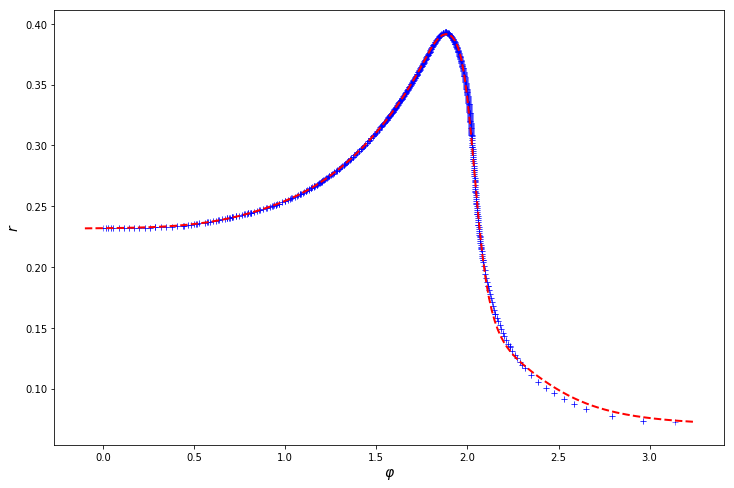

In [146]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
radius_model_scaled.load_state_dict(torch.load("radius_model_scaled.pt"))
model_radius = radius_model_scaled.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_scaled.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_scaled, radius_scaled, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
plt.show()

### Adding artificial data<a id="artificial_data"></a>

In [147]:
phi_threshold = 0.5
phi_add = []
radius_add = []

for p, r in zip(phi_scaled, radius_scaled):
    if p < phi_threshold:
        phi_add.append(-p)
        radius_add.append(r)
    if p > np.pi - phi_threshold:
        phi_add.append(2 * np.pi - p)
        radius_add.append(r)
        
phi_extended = np.concatenate((phi_scaled, np.asarray(phi_add)))
radius_extended = np.concatenate((radius_scaled, np.asarray(radius_add)))
print("Added {} points to the training data.".format(radius_extended.shape[0] - radius_scaled.shape[0]))

Added 52 points to the training data.


In [148]:
radius_model_extended = SimpleMLP(n_layers=6, n_neurons=40)
radius_model_extended = approximate_function(phi_extended, radius_extended, radius_model_extended, max_iter=1500,
                                             l_rate=0.01, path="radius_model_extended.pt")

Loss/max. dev. decreased in epoch 1: 0.01835695624374484/0.341559046413594
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 3: 0.016989565144082844/0.20553037332879726
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 4: 0.010380476404966905/0.2996838798542492
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 7: 0.010013479957704682/0.29717287043568286
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 8: 0.005323209840193801/0.20385838451984117
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 13: 0.004863058806452457/0.22359862714459905
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 42: 0.004861651825609504/0.22403886599251666
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 58: 0.004859936254463361/0.22575456510004333
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 63: 0.004859845

Loss/max. dev. decreased in epoch 214: 0.004853171023776227/0.2255501511281714
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 215: 0.004852760862942491/0.2255600113201433
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 216: 0.004852319207965608/0.22557066251531754
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 217: 0.00485184324791479/0.2255803893629677
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 218: 0.004851329884655896/0.22558863763448056
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 219: 0.004850775725953114/0.22559632176513889
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 220: 0.004850177019283017/0.22560509297822384
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 221: 0.004849529593177017/0.2256161645378063
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 222

Loss/max. dev. decreased in epoch 307: 0.004027874794603136/0.24239763673531245
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 308: 0.004027653317540556/0.24245041496387737
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 309: 0.004027451191691717/0.24248507334630642
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 310: 0.004027253363251592/0.242471064189132
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 311: 0.004027051436680059/0.2424250422565402
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 312: 0.004026844244513601/0.2423897259907417
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 313: 0.004026631502851444/0.2423936041797457
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 314: 0.004026416323361237/0.24243888785238332
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 315

Loss/max. dev. decreased in epoch 388: 0.004021897860247722/0.24263763099493763
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 389: 0.004021873088660105/0.2426379599217795
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 390: 0.00402184855186306/0.24263899041278036
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 391: 0.004021824239560076/0.24264055301549559
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 392: 0.0040218001405204805/0.2426418704179455
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 393: 0.0040217762417536235/0.2426422495112417
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 394: 0.00402175253362745/0.24264175243621022
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 395: 0.004021729009707019/0.24264100836293484
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 3

Loss/max. dev. decreased in epoch 485: 0.004019100977670262/0.24260033147608995
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 486: 0.004019037822695097/0.24259842145080035
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 487: 0.004018972110618152/0.2425964033107494
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 488: 0.00401890365097213/0.24259426948492113
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 489: 0.004018832233568261/0.24259201612753667
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 490: 0.004018757625649289/0.2425896379681975
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 491: 0.004018679568486169/0.24258712231740254
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 492: 0.004018597773275464/0.24258445072566892
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 4

Loss/max. dev. decreased in epoch 554: 0.0013536477206853893/0.14671522655869368
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 557: 0.0007802778481393219/0.1154974190882389
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 560: 0.0005444518115972929/0.07362082416738663
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 563: 0.00019511199850735157/0.04488599781688811
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 578: 9.471901887612598e-05/0.027788343712739
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 582: 5.5250003151424754e-05/0.04175527034003168
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 593: 4.0000119180204405e-05/0.047300506972618395
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 600: 2.9010935508504323e-05/0.037579177476268266
Saving model as radius_model_extended.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 710: 1.1634138546794006e-05/0.021090352820528305
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 711: 1.15959551965977e-05/0.021043515806329086
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 712: 1.1557419712410898e-05/0.021019218262144174
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 713: 1.1519096354814877e-05/0.02096994078917569
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 714: 1.148152575538983e-05/0.020914810320559724
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 715: 1.144378246466275e-05/0.020891044580024956
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 716: 1.1406302053727235e-05/0.020858402718190755
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 717: 1.1369320736509713e-05/0.020816648455953587
Saving model as radius_model_extended.pt
Loss/max. dev

Loss/max. dev. decreased in epoch 810: 8.666066294027303e-06/0.01758895050060623
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 811: 8.641732678880519e-06/0.017554193307694088
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 812: 8.617450964233474e-06/0.017519419293895125
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 813: 8.593220320022547e-06/0.01748486953292866
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 814: 8.569039978813482e-06/0.017450220919368722
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 815: 8.544909200272953e-06/0.017415641565018153
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 816: 8.52082723149283e-06/0.01738118284242912
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 817: 8.496793354391242e-06/0.01734657254884428
Saving model as radius_model_extended.pt
Loss/max. dev. decrea

Loss/max. dev. decreased in epoch 879: 7.081961965804143e-06/0.015282173577606833
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 880: 7.0601857676418565e-06/0.015250115708588002
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 881: 7.038440248337123e-06/0.015218101138467582
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 882: 7.016725387109683e-06/0.015186126925985408
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 883: 6.995041166828243e-06/0.015154187899417748
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 884: 6.97338757333652e-06/0.015122292724431413
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 885: 6.951764596645762e-06/0.015090432035867185
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 886: 6.930172229824558e-06/0.0150586096390872
Saving model as radius_model_extended.pt
Loss/max. dev. dec

Loss/max. dev. decreased in epoch 954: 5.5355455658502125e-06/0.012987080782650165
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 955: 5.516169135696199e-06/0.01295799986224673
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 956: 5.496827453907058e-06/0.012928959624403047
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 957: 5.477520618711746e-06/0.012899959984764467
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 958: 5.458248729127088e-06/0.012871001194033144
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 959: 5.439011884979813e-06/0.012842083028694565
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 960: 5.419810186867543e-06/0.012813205715607984
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 961: 5.400643736181637e-06/0.012784369139533458
Saving model as radius_model_extended.pt
Loss/max. dev. d

Loss/max. dev. decreased in epoch 1046: 3.9126501652440795e-06/0.010484103092196273
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1047: 3.896963771781875e-06/0.010458857428178328
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1048: 3.881323538130076e-06/0.010433655648393145
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1049: 3.865729594732508e-06/0.010408497837319938
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1050: 3.850182071501047e-06/0.010383384078955518
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1051: 3.834681097786772e-06/0.010358314458361481
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1052: 3.819226802351688e-06/0.01033328906268191
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1053: 3.8038193133400528e-06/0.010308307977960035
Saving model as radius_model_extended.pt
Loss/ma

Loss/max. dev. decreased in epoch 1205: 2.757500585396586e-06/0.01024674815009445
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1209: 2.7086787902725853e-06/0.010292020869880042
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1213: 2.6910719285714023e-06/0.010225175911427506
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1214: 2.633587511282887e-06/0.01026313452163781
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1218: 2.5437666830084518e-06/0.010281767136027228
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1222: 2.5064985270606657e-06/0.010031714863562358
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1223: 2.491187296195555e-06/0.009971989454225852
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1226: 2.482757767672704e-06/0.009545757442934344
Saving model as radius_model_extended.pt
Loss/m

Loss/max. dev. decreased in epoch 1299: 1.7926788448170333e-06/0.00757393054079758
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1300: 1.7866980367626175e-06/0.007542225598735797
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1301: 1.7807395659395973e-06/0.007533313391656388
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1302: 1.7748240169153112e-06/0.0075060203369166495
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1303: 1.768970251721906e-06/0.007489545693336291
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1304: 1.7631844017134825e-06/0.007470520092179814
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1305: 1.757457718250175e-06/0.007445202395873901
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1306: 1.751773095345389e-06/0.0074328798934616275
Saving model as radius_model_extended.pt
Lo

Loss/max. dev. decreased in epoch 1393: 1.3854404940430829e-06/0.007330556398450136
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1394: 1.3823144957407367e-06/0.007345626814249023
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1395: 1.3792067354302388e-06/0.0073571817378743215
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1396: 1.3761171563550773e-06/0.007372672127254384
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1397: 1.373045688834176e-06/0.007383322467912901
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1398: 1.3699923942622502e-06/0.007399533021848592
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1399: 1.3669573611505483e-06/0.007408884391369414
Saving model as radius_model_extended.pt
Loss/max. dev. decreased in epoch 1400: 1.3639409316299125e-06/0.007426306374802266
Saving model as radius_model_extended.pt


Maximum relative deviation: 7.94% at angle 2.96.


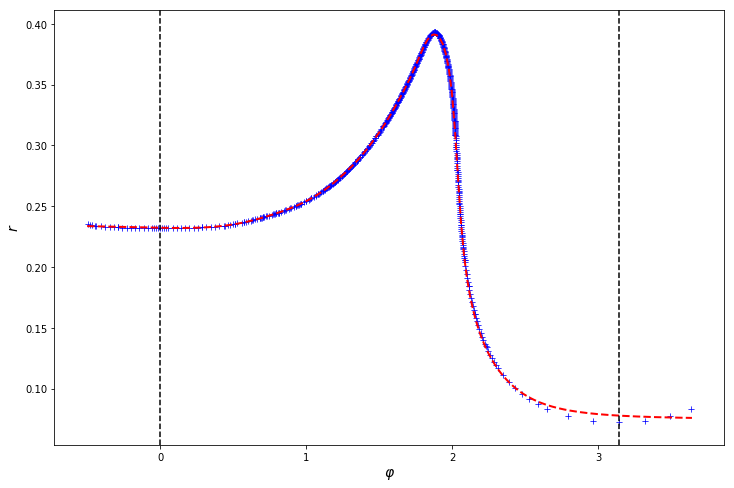

In [149]:
fig, ax = plt.subplots(figsize=(12, 8))

# load best weights and compute forward pass
eval_phi = np.linspace(-0.5, np.pi+0.5, 200)
phi_tensor = torch.from_numpy(eval_phi).unsqueeze_(-1)
radius_model_extended.load_state_dict(torch.load("radius_model_extended.pt"))
model_radius = radius_model_extended.forward(phi_tensor).detach().squeeze().numpy()
# evaluate maximum relative deviation (only in 0...pi)
phi_data_tensor = torch.from_numpy(phi_scaled).unsqueeze_(-1)
model_radius_data = radius_model_extended.forward(phi_data_tensor).detach().squeeze().numpy()
diff = np.absolute(model_radius_data - radius_scaled)
diff_max_pos = np.argmax(diff)
print(r"Maximum relative deviation: {:2.2f}% at angle {:2.2f}.".format(
    np.amax(diff)/radius_scaled[diff_max_pos] * 100, phi_scaled[diff_max_pos]))

ax.plot(eval_phi, model_radius, linewidth=2, linestyle="--", c='r')
ax.scatter(phi_extended, radius_extended, marker='+', color='b', s=30, linewidth=0.5)
ax.set_xlabel(r"$\varphi$", fontsize=fontsize)
ax.set_ylabel(r"$r$", fontsize=fontsize)
ax.axvline(0.0, 0.0, 1.0, color='k', linestyle='--')
ax.axvline(np.pi, 0.0, 1.0, color='k', linestyle='--')
plt.show()

## Final notes<a id="final_notes"></a>

- play around with the number of layers and neurons per layer
- many layers, sigmoid suffers from vanishing gradient, change activation function, e.g., to *torch.relu*
- create a custom loss funtion that weights each individual inversly to the distribution of the training data over the polar angle.